In [1]:
%reset
import netCDF4
import numpy as np
import glob
import xarray as xr

import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
print('done')

done


In [3]:
grdfile = '/glade/derecho/scratch/eyankovsky/EASTPAC25KM/epac25km_grd.nc'
initfile =  '/glade/derecho/scratch/eyankovsky/EASTPAC25KM/epac25km_ini.nc'

grd = xr.open_dataset(grdfile)
dx = 1/grd.pm; dy = 1/grd.pn;
area=dx*dy

ALK = xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/ALK_forcing.nc').ALK[1,:,:]
total_alk_Jan = np.nansum(ALK*31.0*86400*area)
total_alk_Apr = np.nansum(ALK*30.0*86400*area)
total_alk_Jul = np.nansum(ALK*31.0*86400*area)
total_alk_Oct = np.nansum(ALK*31.0*86400*area)
total_alk_1yr = np.nansum(ALK*365.0*86400*area)
total_alk_3yr = np.nansum(ALK*365.0*3*86400*area)

#Reading in January and Control:
infiles_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jan_data/eastpac25km_rst.*.nc')
infiles_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Apr_data/eastpac25km_rst.*.nc')
infiles_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jul_data/eastpac25km_rst.*.nc')
infiles_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Oct_data/eastpac25km_rst.*.nc')
infiles_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_1yr_data/eastpac25km_rst.*.nc')
infiles_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_5yr_data/eastpac25km_rst.*.nc')
infiles_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Control_data/eastpac25km_rst.*.nc')

bgc_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jan_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Apr_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Jul_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Oct_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_1yr_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_5yr_data/eastpac25km_bgc_dia_avg.*.nc')
bgc_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/EASTPAC25KM_Control_data/eastpac25km_bgc_dia_avg.*.nc')

infiles_Jan.sort(); infiles_Apr.sort(); infiles_Jul.sort(); infiles_Oct.sort(); infiles_1YR.sort(); infiles_3YR.sort(); infiles_ctl.sort(); 
bgc_Jan.sort(); bgc_Apr.sort(); bgc_Jul.sort(); bgc_Oct.sort(); bgc_1YR.sort(); bgc_3YR.sort(); bgc_ctl.sort();
print('done')

done


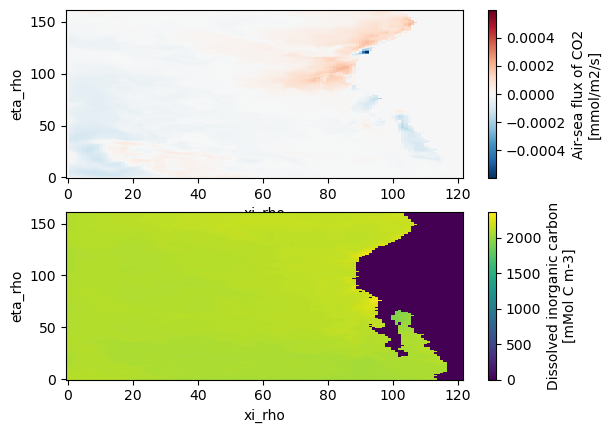

In [4]:
ii = 33
#Jan 33; Apr 33; Jul 33; Oct 33; 1YR 33; Ctl 
test1=xr.open_dataset(bgc_ctl[ii])['FG_CO2']
test2=xr.open_dataset(infiles_ctl[ii])['DIC'][0,-1,:,:]

plt.subplot(2,1,1)
test1.plot()
plt.subplot(2,1,2)
test2.plot()

In [5]:
def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

def get_thickness(zeta, h):
    
    N = 100
    theta_s = 6
    theta_b = 6
    hc = 250

    k_w = np.linspace(0,N,N+1)

    sigma_w = (k_w - N) / N

    Cs_w = Cs(sigma_w, theta_s, theta_b)

    S_w = np.zeros((N+1, h.shape[0], h.shape[1]))

    for k in range(N+1):
        S_w[k,:,:] = (hc * sigma_w[k] + h*Cs_w[k]) / (hc + h)
                
    z_w = np.zeros((N+1, h.shape[0], h.shape[1]))
    for k in range(N+1):
        z_w[k,:,:] = zeta + (zeta + h)*S_w[k,:,:]

    H = np.diff(z_w,axis=0)
    
    return H

In [7]:
#ALK_forced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])
#ALK_unforced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])
h = xr.open_dataset(grdfile)['h'][:,:]

time = np.zeros(len(infiles_ctl))
fraction_Jan = np.zeros(len(infiles_ctl))
# fraction_1yr = np.zeros(len(infiles_ctl))
# fraction_3yr = np.zeros(len(infiles_ctl))

ALK_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])



In [8]:
for index in range(10): #range(len(infiles)):
    print(index)
    ALK_forced_Jan = xr.open_dataset(infiles_Jan[index])['Alk'][1,:,:,:]
    DIC_forced_Jan = xr.open_dataset(infiles_Jan[index])['DIC'][1,:,:,:]
    flux_Jan = xr.open_dataset(bgc_Jan[index])['FG_CO2'][0,:,:]

    ALK_forced_Apr = xr.open_dataset(infiles_Apr[index])['Alk'][1,:,:,:]
    DIC_forced_Apr = xr.open_dataset(infiles_Apr[index])['DIC'][1,:,:,:]
    flux_Apr = xr.open_dataset(bgc_Apr[index])['FG_CO2'][0,:,:]

    ALK_forced_Jul = xr.open_dataset(infiles_Jul[index])['Alk'][1,:,:,:]
    DIC_forced_Jul = xr.open_dataset(infiles_Jul[index])['DIC'][1,:,:,:]
    flux_Jul = xr.open_dataset(bgc_Jul[index])['FG_CO2'][0,:,:]

    ALK_forced_Oct = xr.open_dataset(infiles_Oct[index])['Alk'][1,:,:,:]
    DIC_forced_Oct = xr.open_dataset(infiles_Oct[index])['DIC'][1,:,:,:]
    flux_Oct = xr.open_dataset(bgc_Oct[index])['FG_CO2'][0,:,:]

    ALK_forced_1yr = xr.open_dataset(infiles_1YR[index])['Alk'][1,:,:,:]
    DIC_forced_1yr = xr.open_dataset(infiles_1YR[index])['DIC'][1,:,:,:]
    flux_1yr = xr.open_dataset(bgc_1YR[index])['FG_CO2'][0,:,:]

    ALK_forced_3yr = xr.open_dataset(infiles_3YR[index])['Alk'][1,:,:,:]
    DIC_forced_3yr = xr.open_dataset(infiles_3YR[index])['DIC'][1,:,:,:]
    flux_3yr = xr.open_dataset(bgc_3YR[index])['FG_CO2'][0,:,:]

    ALK_unforced = xr.open_dataset(infiles_ctl[index])['Alk'][1,:,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[index])['DIC'][1,:,:,:]
    flux_unforced = xr.open_dataset(bgc_ctl[index])['FG_CO2'][0,:,:]
    
    SSH = xr.open_dataset(infiles_ctl[index])['zeta'][1,:,:]
    H = get_thickness(SSH,h)
    
    ALK_forced_ws_Jan = (ALK_forced_Jan*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Apr = (ALK_forced_Apr*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Jul = (ALK_forced_Jul*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Oct = (ALK_forced_Oct*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_1yr = (ALK_forced_1yr*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_3yr = (ALK_forced_3yr*H).sum(axis=0)*area     #mMol
    ALK_unforced_ws = (ALK_unforced*H).sum(axis=0)*area #mMol    
    
    ALK_diff_Jan[index] = ALK_forced_ws_Jan-ALK_unforced_ws
    ALK_diff_Apr[index] = ALK_forced_ws_Apr-ALK_unforced_ws
    ALK_diff_Jul[index] = ALK_forced_ws_Jul-ALK_unforced_ws
    ALK_diff_Oct[index] = ALK_forced_ws_Oct-ALK_unforced_ws
    ALK_diff_1yr[index] = ALK_forced_ws_1yr-ALK_unforced_ws
    ALK_diff_3yr[index] = ALK_forced_ws_3yr-ALK_unforced_ws

    DIC_forced_ws_Jan = (DIC_forced_Jan*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Apr = (DIC_forced_Apr*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Jul = (DIC_forced_Jul*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Oct = (DIC_forced_Oct*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_1yr = (DIC_forced_1yr*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_3yr = (DIC_forced_3yr*H).sum(axis=0)*area     #mMol
    DIC_unforced_ws = (DIC_unforced*H).sum(axis=0)*area #mMol
    
    DIC_diff_Jan[index] = DIC_forced_ws_Jan-DIC_unforced_ws
    DIC_diff_Apr[index] = DIC_forced_ws_Apr-DIC_unforced_ws
    DIC_diff_Jul[index] = DIC_forced_ws_Jul-DIC_unforced_ws
    DIC_diff_Oct[index] = DIC_forced_ws_Oct-DIC_unforced_ws
    DIC_diff_1yr[index] = DIC_forced_ws_1yr-DIC_unforced_ws
    DIC_diff_3yr[index] = DIC_forced_ws_3yr-DIC_unforced_ws

    flux_diff_Jan[index] = flux_Jan-flux_unforced
    flux_diff_Apr[index] = flux_Apr-flux_unforced
    flux_diff_Jul[index] = flux_Jul-flux_unforced
    flux_diff_Oct[index] = flux_Oct-flux_unforced
    flux_diff_1yr[index] = flux_1yr-flux_unforced
    flux_diff_3yr[index] = flux_3yr-flux_unforced

    time[index] = xr.open_dataset(infiles_ctl[index])['ocean_time'][1]


    fraction_Jan[index] = np.nansum(ALK_diff_Jan[index])/total_alk_Jan


0
1
2
3
4
5
6
7
8
9


In [12]:
H[:,50,40]

array([  6.89039068,   8.35304705,  10.13383368,  12.25862281,
        14.74573211,  17.60435569,  20.83343098,  24.42102287,
        28.34426281,  32.56983541,  37.05496491,  41.74882145,
        46.59424456,  51.52966935,  56.49113969,  61.41429961,
        66.23626827,  70.89732219,  75.34232909,  79.5218988 ,
        83.39323595,  86.92069668,  90.07606549,  92.83857892,
        95.19472995,  97.13789123,  98.66779636,  99.78991759,
       100.51477603, 100.85721628, 100.83567346, 100.47145538,
        99.78805825,  98.81052955,  97.5648876 ,  96.07760381,
        94.37515032,  92.48361333,  90.42837046,  88.2338286 ,
        85.92321821,  83.51843869,  81.03994956,  78.50670171,
        75.93610332,  73.34401495,  70.74476898,  68.1512087 ,
        65.57474297,  63.0254127 ,  60.51196591,  58.0419387 ,
        55.62173955,  53.25673518,  50.95133622,  48.70908135,
        46.53271905,  44.42428589,  42.38518112,  40.41623683,
        38.51778367,  36.68971191,  34.93152777,  33.24

In [170]:
integrated_ALK = np.zeros(len(infiles_ctl))
integrated_DIC = np.zeros(len(infiles_ctl))
for index in range(len(bgc_Jan)): #range(len(infiles)):

    ALK_unforced= xr.open_dataset(infiles_ctl[index])['Alk'][1,:,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[index])['DIC'][1,:,:,:]
    
    SSH = xr.open_dataset(infiles_ctl[index])['zeta'][1,:,:]
    H = get_thickness(SSH,h)
    integrated_ALK[index] = np.nansum((ALK_unforced*H).sum(axis=0)*area) #mMol    
    integrated_DIC[index] = np.nansum((DIC_unforced*H).sum(axis=0)*area) #mMol    
    
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


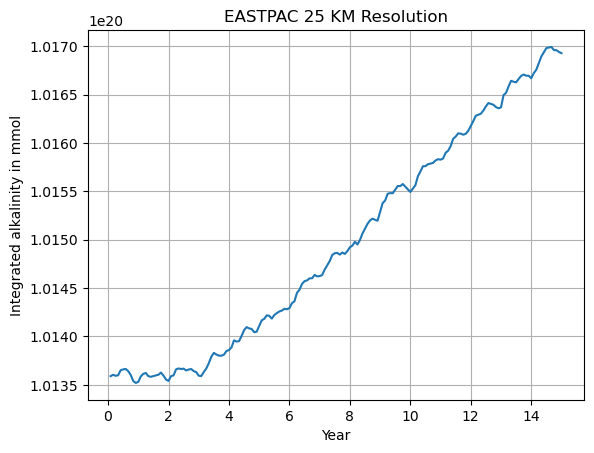

In [179]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,integrated_ALK)
plt.xlabel('Year')
plt.ylabel('Integrated alkalinity in mmol')
plt.title('EASTPAC 25 KM Resolution')
plt.grid()

Text(0, 0.5, 'Fraction')

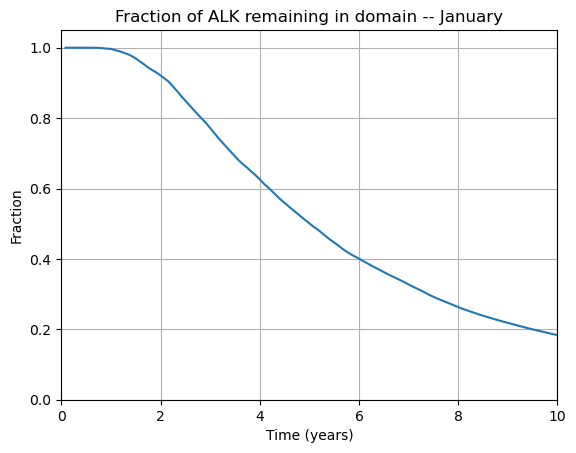

In [17]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,fraction_Jan)
plt.title('Fraction of ALK remaining in domain -- January')
plt.grid(); plt.xlim([0,10]); plt.ylim([0,1.05]);
plt.xlabel('Time (years)'); plt.ylabel('Fraction')

In [98]:
f8 = np.cumsum(np.nansum(np.nansum(flux_diff_Oct[9:]*86400*30.42*area.values,axis=1),axis=1))/total_alk_Oct
f8

array([0.13689696, 0.34323109, 0.35562702, 0.38935623, 0.42033603,
       0.44774895, 0.46035299, 0.4653473 , 0.47998475, 0.48817414,
       0.49619896, 0.50264317, 0.51132271, 0.51796975, 0.52564139,
       0.53268091, 0.53689813, 0.54376773, 0.54840502, 0.5512042 ,
       0.55257219, 0.55471121, 0.55752195, 0.55844466, 0.55996671,
       0.56175676, 0.56409479, 0.56552529, 0.56746967, 0.56954624,
       0.57132383, 0.57297568, 0.57379776, 0.57462989, 0.57530529,
       0.57628165, 0.57776533, 0.57869424, 0.57936362, 0.58085234,
       0.5817255 , 0.58230162, 0.58350159, 0.58388024, 0.58450871,
       0.5850315 , 0.58542709, 0.5859495 , 0.58633265, 0.58662858,
       0.58713901, 0.58848148, 0.58889344, 0.58938054, 0.5900046 ,
       0.59031016, 0.59067427, 0.59084349, 0.59108856, 0.59130939,
       0.59141754, 0.59158946, 0.59202198, 0.59225821, 0.59253544,
       0.59271456, 0.59307313, 0.59331165, 0.5934807 , 0.59359857,
       0.59384015, 0.59402171, 0.59413559, 0.59430671, 0.59457

Text(0, 0.5, '$\\eta$')

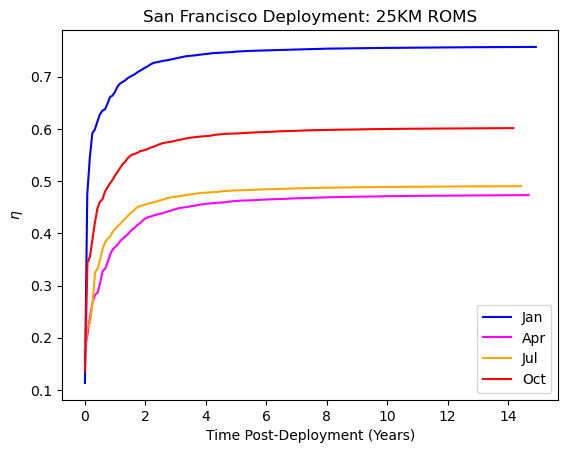

In [84]:
plt.plot((time-time[0])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jan[0:]*86400*30.42*area.values,axis=1),axis=1))/total_alk_Jan,label='Jan',color='blue')
plt.plot((time[3:]-time[3])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Apr[3:]*86400*30.42*area.values,axis=1),axis=1))/total_alk_Apr,label='Apr',color='fuchsia')
plt.plot((time[6:]-time[6])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jul[6:]*86400*30.42*area.values,axis=1),axis=1))/total_alk_Jul,label='Jul',color='orange')
plt.plot((time[9:]-time[9])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Oct[9:]*86400*30.42*area.values,axis=1),axis=1))/total_alk_Oct,label='Oct',color='red')
plt.legend()
plt.title('San Francisco Deployment: 25KM ROMS')
#plt.grid(); plt.xlim([0,9]); plt.ylim([0,0.8]);
plt.xlabel('Time Post-Deployment (Years)'); plt.ylabel('$\eta$')

Text(0, 0.5, '$\\eta$')

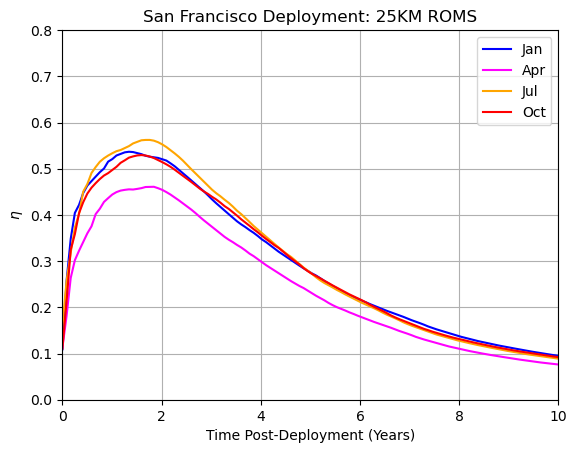

In [165]:
plt.plot(np.linspace(0,14,168),np.nansum(np.nansum(DIC_diff_Jan[0:168],axis=1),axis=1)/total_alk_Jan,label='Jan',color='blue')
plt.plot(np.linspace(0,14,168),np.nansum(np.nansum(DIC_diff_Apr[3:171],axis=1),axis=1)/total_alk_Apr,label='Apr',color='fuchsia')
plt.plot(np.linspace(0,14,168),np.nansum(np.nansum(DIC_diff_Jul[6:174],axis=1),axis=1)/total_alk_Jul,label='Jul',color='orange')
plt.plot(np.linspace(0,14,168),np.nansum(np.nansum(DIC_diff_Oct[9:177],axis=1),axis=1)/total_alk_Oct,label='Oct',color='red')
plt.legend()
plt.title('San Francisco Deployment: 25KM ROMS')
plt.grid(); plt.xlim([0,10]); plt.ylim([0,0.8]);
plt.xlabel('Time Post-Deployment (Years)'); plt.ylabel('$\eta$')

In [21]:
t = np.array(range(14*12))


IRF_01 = np.nansum(np.nansum(DIC_diff_Jan[0:168],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Jan[0:168],axis=1),axis=1)
IRF_04 = np.nansum(np.nansum(DIC_diff_Apr[3:171],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Apr[3:171],axis=1),axis=1)
IRF_07 = np.nansum(np.nansum(DIC_diff_Jul[6:174],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Jul[6:174],axis=1),axis=1)
IRF_10 = np.nansum(np.nansum(DIC_diff_Oct[9:177],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Oct[9:177],axis=1),axis=1)

IRF_02 = IRF_01*(2/3) + IRF_04*(1/3)
IRF_03 = IRF_01*(1/3) + IRF_04*(2/3)
IRF_05 = IRF_04*(2/3) + IRF_07*(1/3)
IRF_06 = IRF_04*(1/3) + IRF_07*(2/3)
IRF_08 = IRF_07*(2/3) + IRF_10*(1/3)
IRF_09 = IRF_07*(1/3) + IRF_10*(2/3)
IRF_11 = IRF_10*(2/3) + IRF_01*(1/3)
IRF_12 = IRF_10*(1/3) + IRF_01*(2/3)

IRF_13 = IRF_01; IRF_25 = IRF_01; IRF_37 = IRF_01; IRF_49 = IRF_01;
IRF_14 = IRF_02; IRF_26 = IRF_02; IRF_38 = IRF_02; IRF_50 = IRF_02;
IRF_15 = IRF_03; IRF_27 = IRF_03; IRF_39 = IRF_03; IRF_51 = IRF_03;
IRF_16 = IRF_04; IRF_28 = IRF_04; IRF_40 = IRF_04; IRF_52 = IRF_04;
IRF_17 = IRF_05; IRF_29 = IRF_05; IRF_41 = IRF_05; IRF_53 = IRF_05;
IRF_18 = IRF_06; IRF_30 = IRF_06; IRF_42 = IRF_06; IRF_54 = IRF_06;
IRF_19 = IRF_07; IRF_31 = IRF_07; IRF_43 = IRF_07; IRF_55 = IRF_07;
IRF_20 = IRF_08; IRF_32 = IRF_08; IRF_44 = IRF_08; IRF_56 = IRF_08;
IRF_21 = IRF_09; IRF_33 = IRF_09; IRF_45 = IRF_09; IRF_57 = IRF_09;
IRF_22 = IRF_10; IRF_34 = IRF_10; IRF_46 = IRF_10; IRF_58 = IRF_10;
IRF_23 = IRF_11; IRF_35 = IRF_11; IRF_47 = IRF_11; IRF_59 = IRF_11;
IRF_24 = IRF_12; IRF_36 = IRF_12; IRF_48 = IRF_12; IRF_60 = IRF_12;

1
2
3
4
5
6
7
8
9
10
11
12


([<matplotlib.axis.XTick at 0x14fc941a98d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

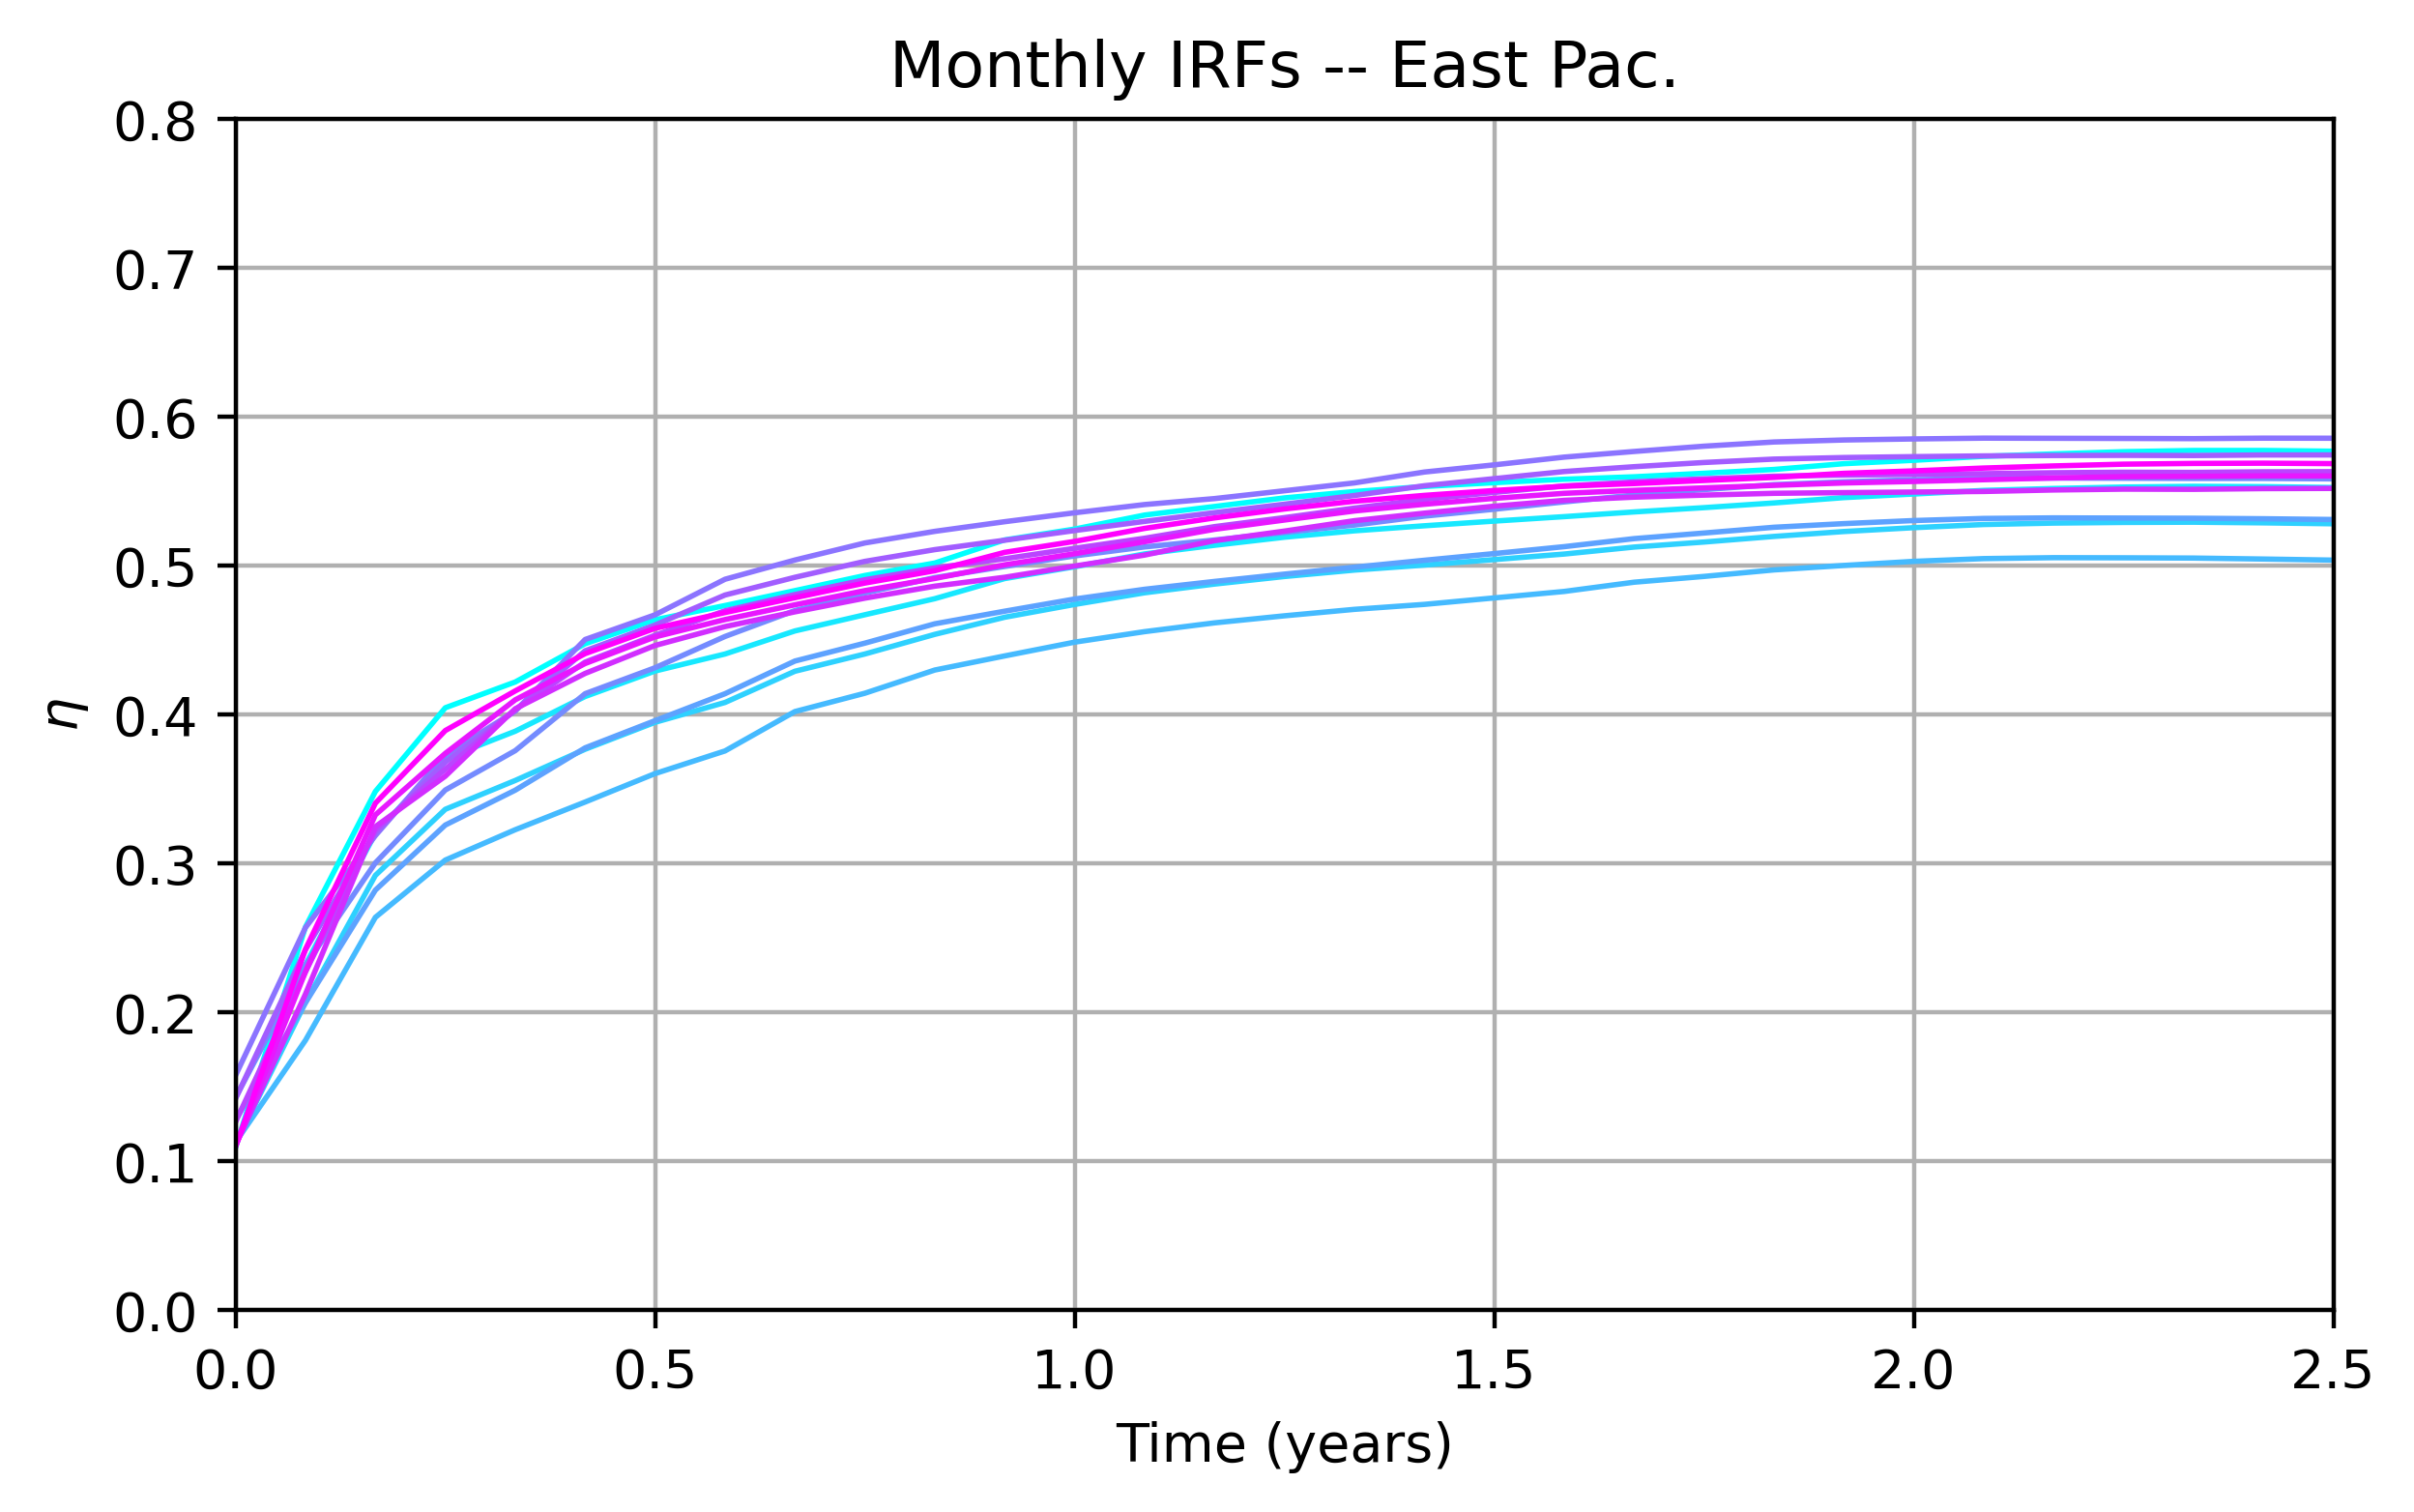

In [22]:
fig = plt.figure(figsize=(7,4),dpi=400)

color = iter(plt.cm.cool(np.linspace(0, 1, 12)))

   

for i in range(1,13):
    print(i)
    c = next(color)
    #print(globals()[f'IRF_{i:02d}'])
    plt.plot(t/12,globals()[f'IRF_{i:02d}'],label=f'IRF Month {i:02d}',c=c,linewidth=1)
#plt.legend()
plt.ylabel('$\eta$')
plt.xlabel('Time (years)')
plt.title('Monthly IRFs -- East Pac.')
#plt.plot([0, 190],[0.85,0.85])
plt.grid('on')
plt.xlim([0,2.5])
plt.ylim([0,.8])
plt.xticks(np.linspace(0,2.5,6))

0
1
2
3
4
5
6
7
8
9
10
11


Text(0, 0.5, '$\\eta$')

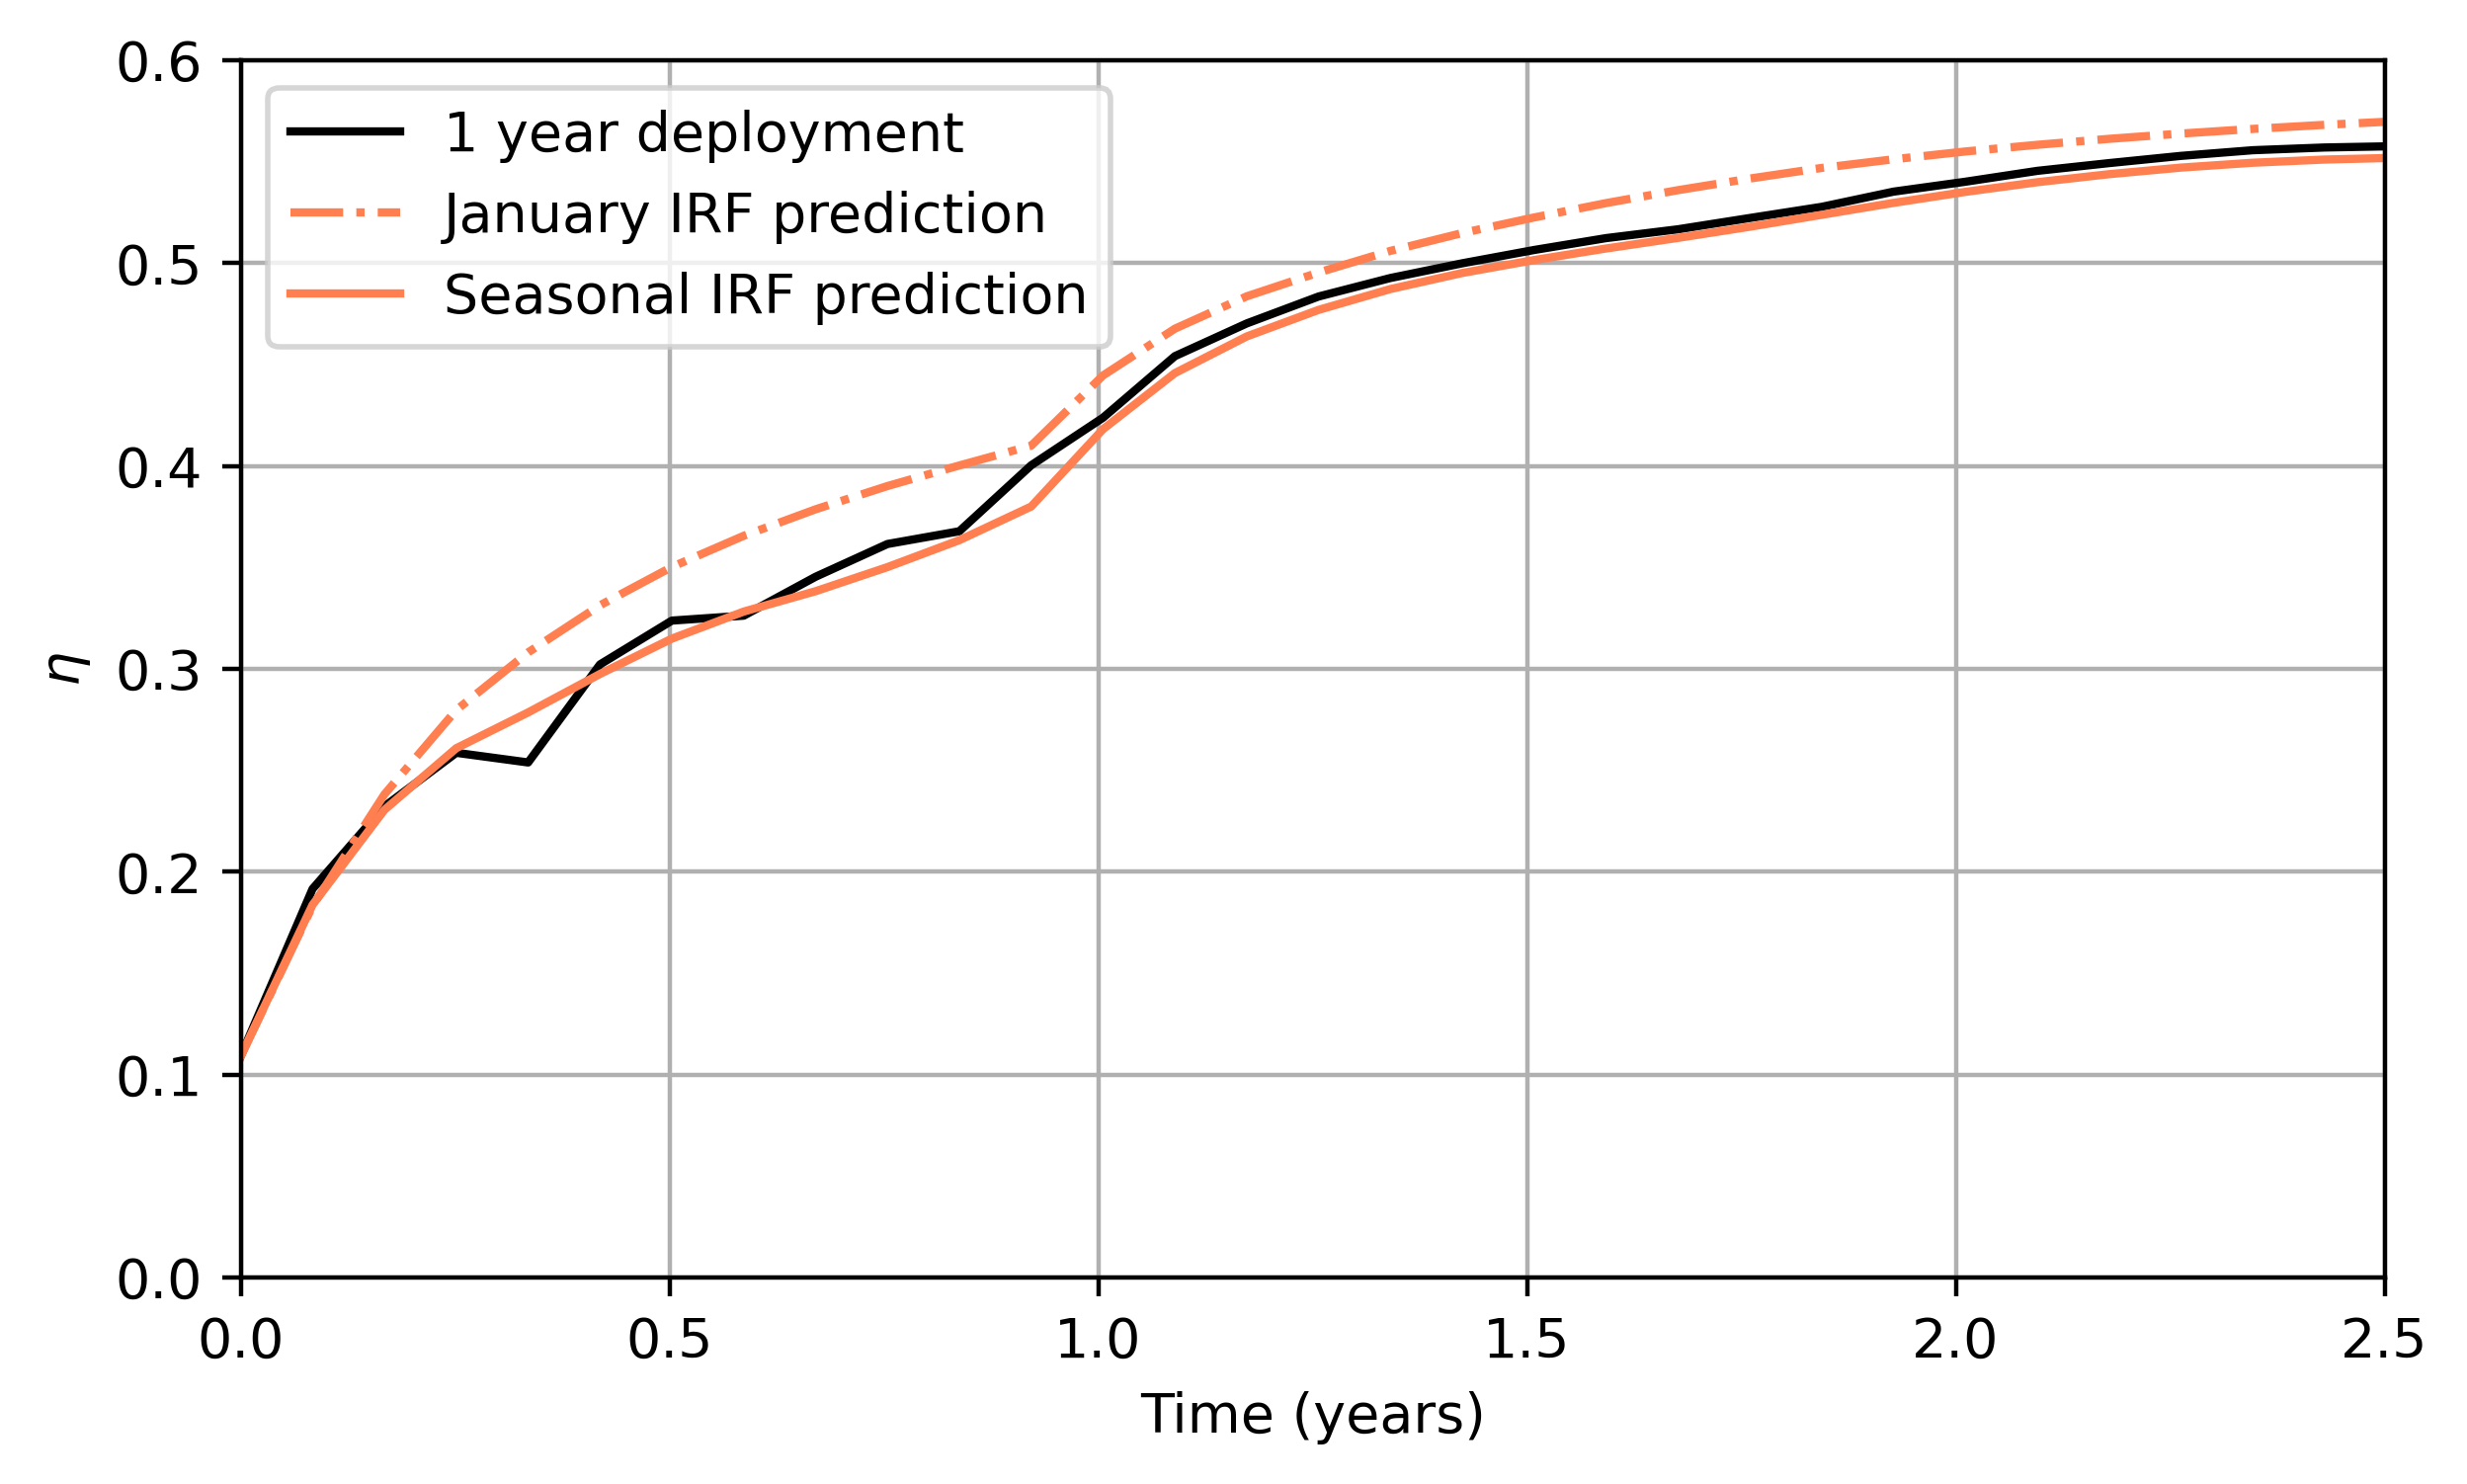

In [23]:
fig = plt.figure(figsize=(7,4),dpi=400)

ALK_added_total = ((xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/ALK_forcing.nc').ALK[:]*86400*1e3/365)*area).sum(axis=1).sum(axis=1) #mol/day
ALK_added_total=ALK_added_total[0:180]; ALK_added_total[12:180]=0;
convolution_simple1 = np.convolve(ALK_added_total, IRF_01)

ALK_added_local = np.zeros(ALK_added_total.shape); ALK_added_local[0]=ALK_added_total[0]
convolution1    = np.zeros(ALK_added_total.shape);
for i in range(0,12):
    print(i)
    #ALk_added_local = np.zeros(ALk_added_total.shape); ALk_added_local[i]=ALk_added_total[i]
    convolution_local = np.convolve(ALK_added_local, globals()[f'IRF_{i+1:02d}'])
    convolution1[i:168] = convolution1[i:168] + convolution_local[0:168-i]

plt.plot(np.linspace(0,15,180),np.nansum(np.nansum(DIC_diff_1yr[0:180],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_1yr[0:180],axis=1),axis=1),label='1 year deployment',color='black')
plt.plot(np.linspace(0,15,180),convolution_simple1[0:180]/np.cumsum(ALK_added_total),'-.',label='January IRF prediction',color='coral')

plt.plot(np.linspace(0,15,180),convolution1/np.cumsum(ALK_added_total),label='Seasonal IRF prediction',color='coral')





plt.xlim([0,2.5]); plt.ylim([0,0.6])
plt.grid(); plt.legend(); plt.xlabel('Time (years)'); plt.ylabel('$\eta$')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


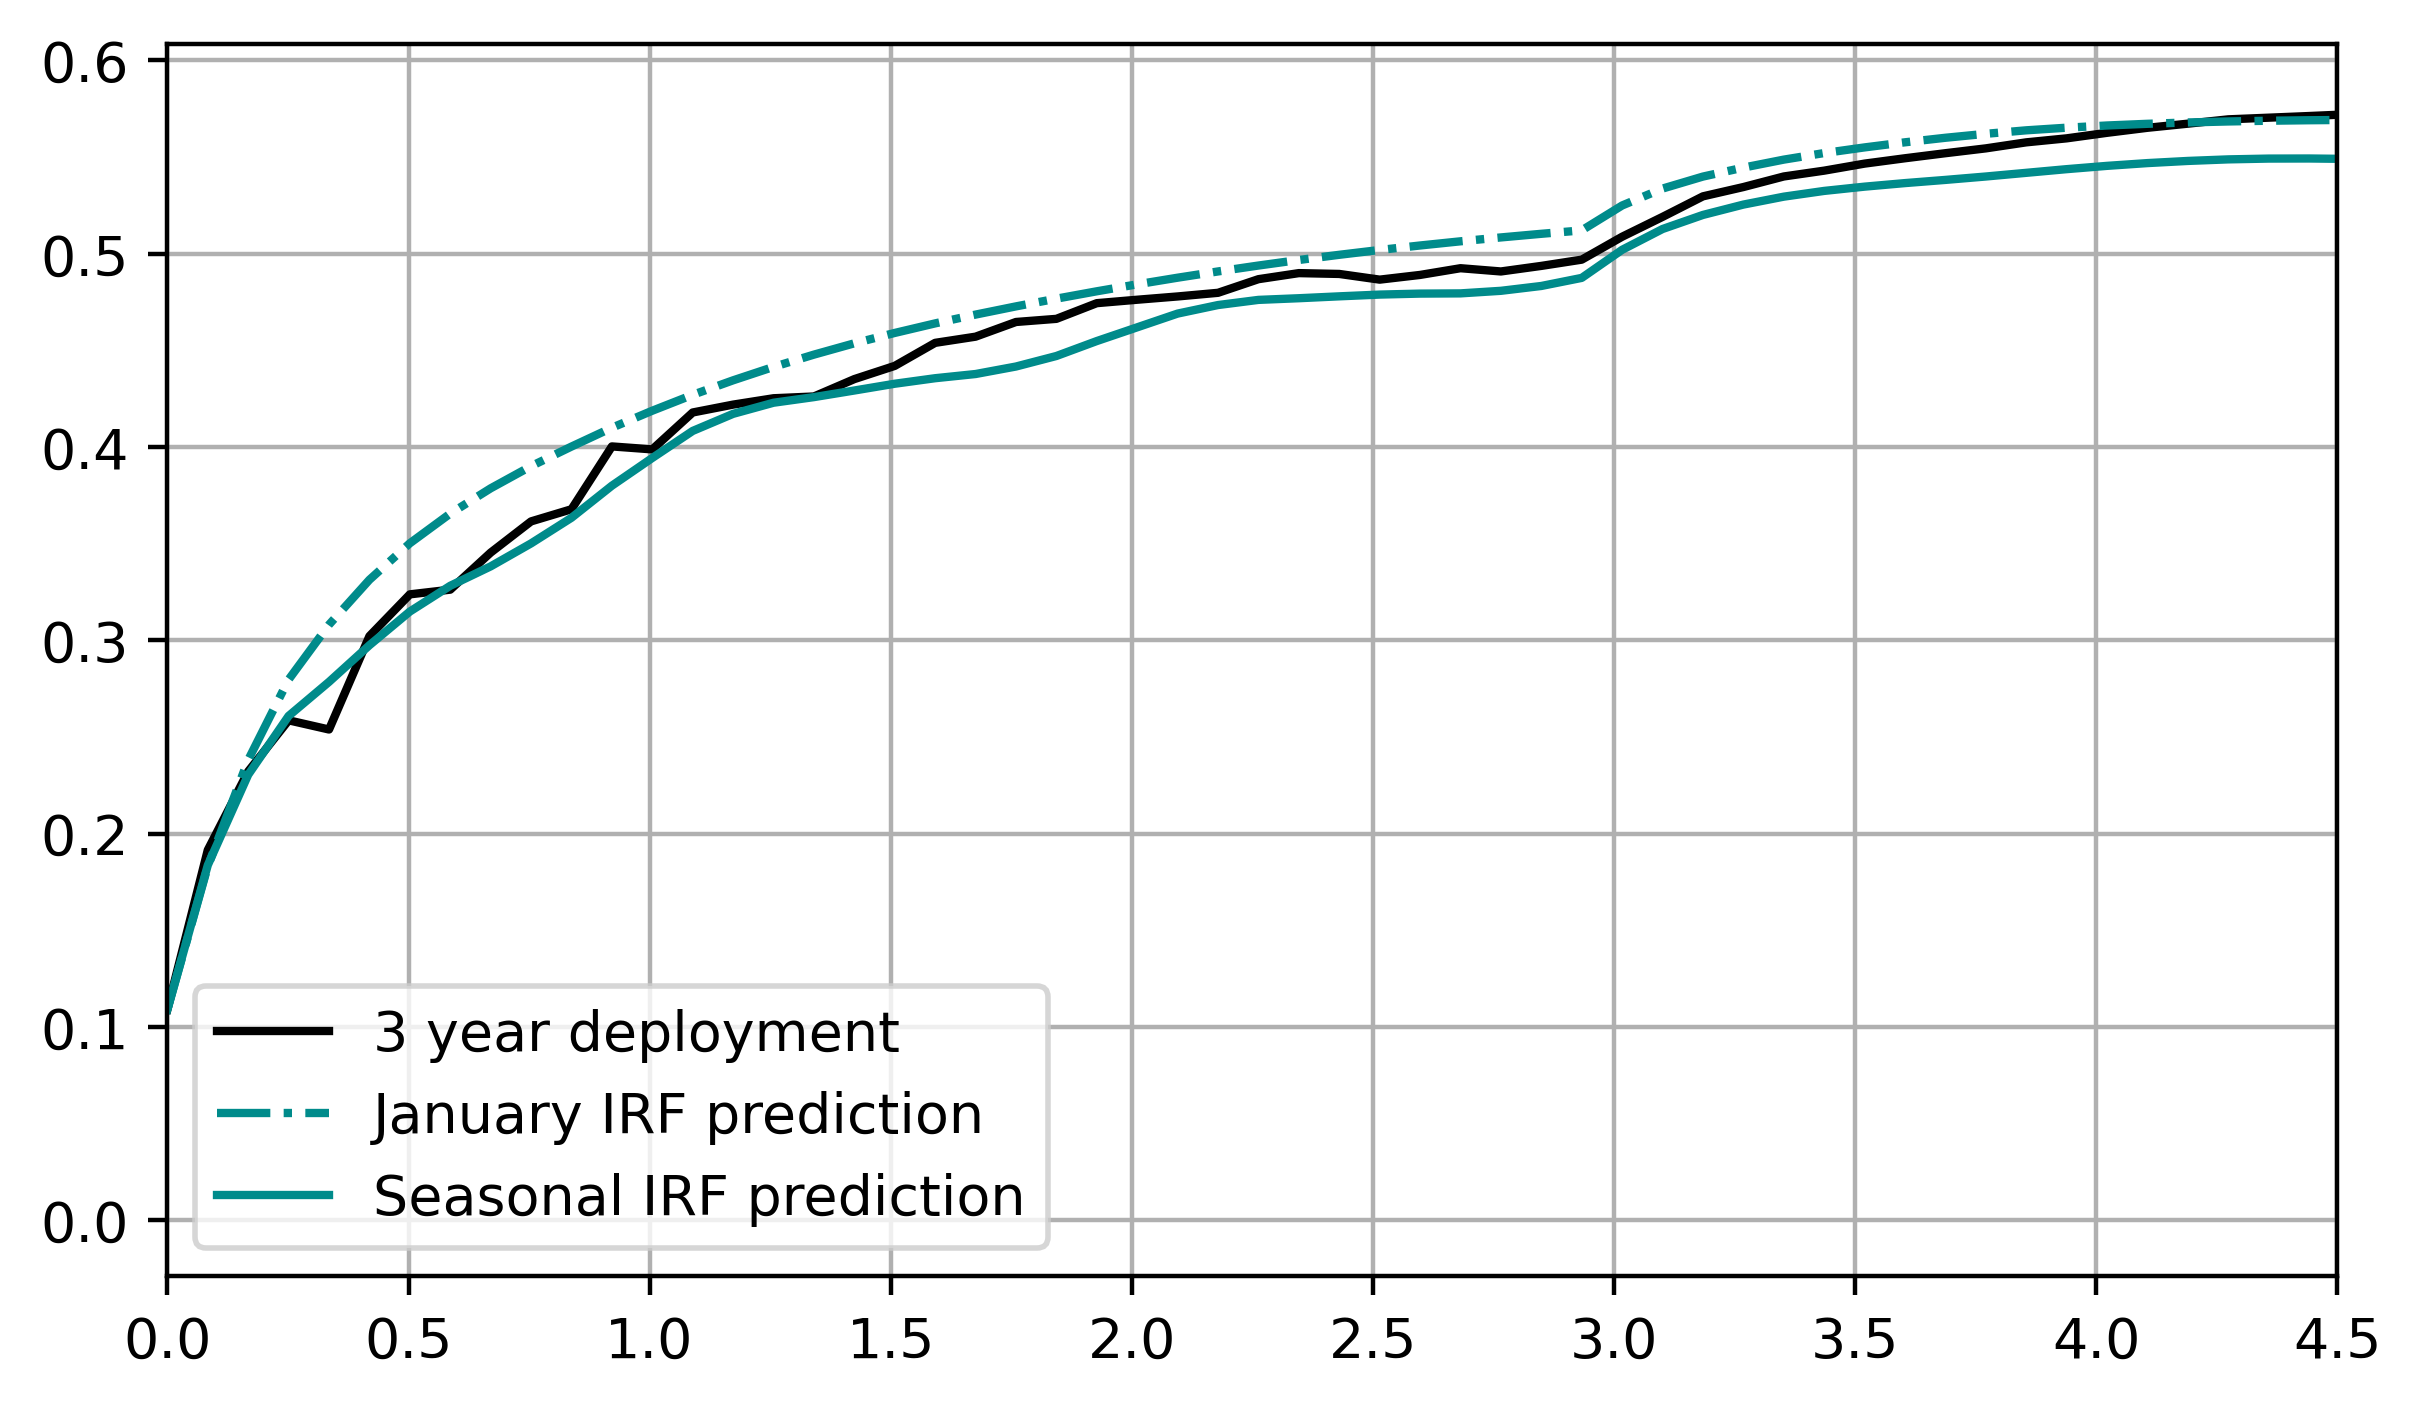

In [24]:
fig = plt.figure(figsize=(7,4),dpi=400)

ALK_added_total = ((xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/ALK_forcing.nc').ALK[:]*86400*1e3/365)*area).sum(axis=1).sum(axis=1) #mol/day
ALK_added_total=ALK_added_total[0:180]; ALK_added_total[36:180]=0;
convolution_simple3 = np.convolve(ALK_added_total, IRF_01)

ALK_added_local = np.zeros(ALK_added_total.shape); ALK_added_local[0]=ALK_added_total[0]
convolution3    = np.zeros(ALK_added_total.shape);
for i in range(0,36):
    print(i)
    #ALk_added_local = np.zeros(ALk_added_total.shape); ALk_added_local[i]=ALk_added_total[i]
    convolution_local = np.convolve(ALK_added_local, globals()[f'IRF_{i+1:02d}'])
    convolution3[i:168] = convolution3[i:168] + convolution_local[0:168-i]

plt.plot(np.linspace(0,15,180),np.nansum(np.nansum(DIC_diff_3yr[0:180],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_3yr[0:180],axis=1),axis=1),label='3 year deployment',color='black')
plt.plot(np.linspace(0,15,180),convolution_simple3[0:180]/np.cumsum(ALK_added_total),'-.',label='January IRF prediction',color='darkcyan')
plt.plot(np.linspace(0,15,180),convolution3/np.cumsum(ALK_added_total),label='Seasonal IRF prediction',color='darkcyan')
plt.xlim([0,4.5])
plt.grid(); plt.legend()

In [25]:
IRF_10[0:60]

array([0.11047027, 0.21206183, 0.3245565 , 0.35844411, 0.40373886,
       0.42748174, 0.44624653, 0.45893159, 0.46882616, 0.47802118,
       0.48607048, 0.4920563 , 0.49959919, 0.50696046, 0.51664131,
       0.52307728, 0.53005976, 0.53511671, 0.53980504, 0.54371558,
       0.54587074, 0.54723984, 0.54845311, 0.54890585, 0.5492853 ,
       0.54969508, 0.55068733, 0.55124936, 0.55113315, 0.55160679,
       0.55177411, 0.55197419, 0.55158843, 0.55133902, 0.55104095,
       0.5510686 , 0.55101873, 0.55143578, 0.55136405, 0.55149451,
       0.55175775, 0.55158093, 0.55162766, 0.55089323, 0.55028022,
       0.54963406, 0.54882888, 0.54814406, 0.54716542, 0.54633638,
       0.54617397, 0.545729  , 0.54529672, 0.54456381, 0.54343741,
       0.54242891, 0.54133556, 0.54003687, 0.53837416, 0.53693497])

In [26]:
depth = np.ma.array(grd.mask_rho)#, mask=grd.hraw >0)
mask= grd.mask_rho.where(grd.mask_rho>0)

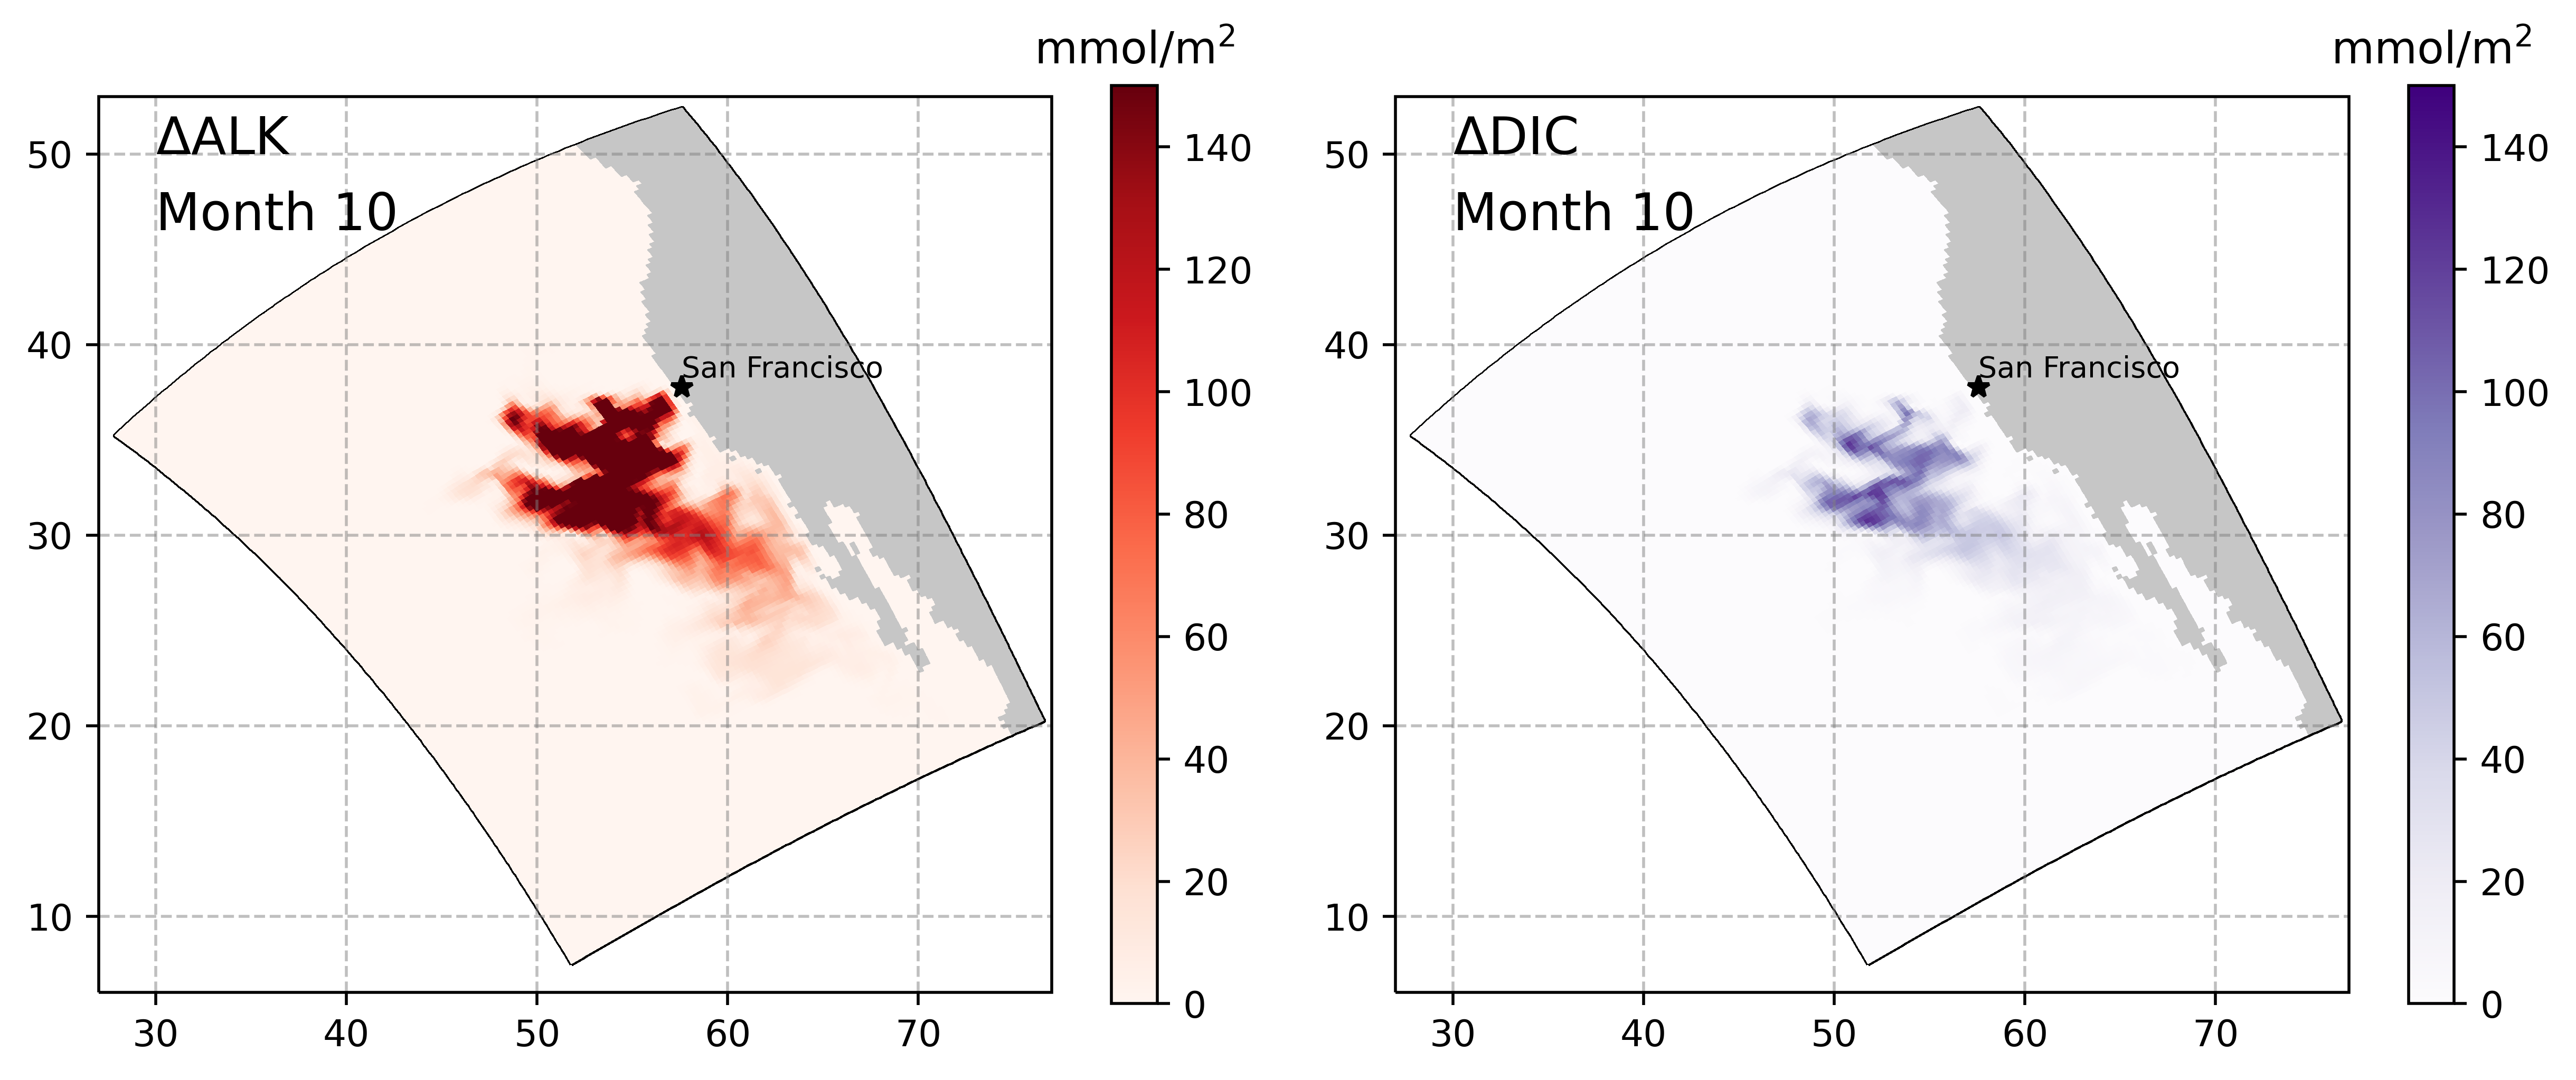

In [99]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



ii=9

fig = plt.figure(figsize=(10,5),dpi=500)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                ALK_diff_3yr[ii]*mask/area,
                transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Reds');
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);


cb.ax.set_title('mmol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta$ALK', fontsize=14)

plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)


ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter() 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                DIC_diff_3yr[ii]*mask/area,
                transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Purples');
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);


cb.ax.set_title('mmol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta$DIC', fontsize=14)

plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)


ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter() 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
plt.tight_layout()


In [79]:
flux_Jan

<xarray.DataArray 'FG_CO2' (eta_rho: 162, xi_rho: 122)>
array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -1.595878e-04, -1.712606e-04, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00, -1.710348e-04, -1.775087e-04, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       ...,
       [ 0.000000e+00,  3.961886e-05,  1.335668e-05, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  5.280379e-05,  3.009551e-05, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]], dtype=float32)
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  Air-sea flux of CO2
    units:      mmol/m2/s

/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix_r").copy()


Text(0.5, 1.07, '25 KM Resolution')

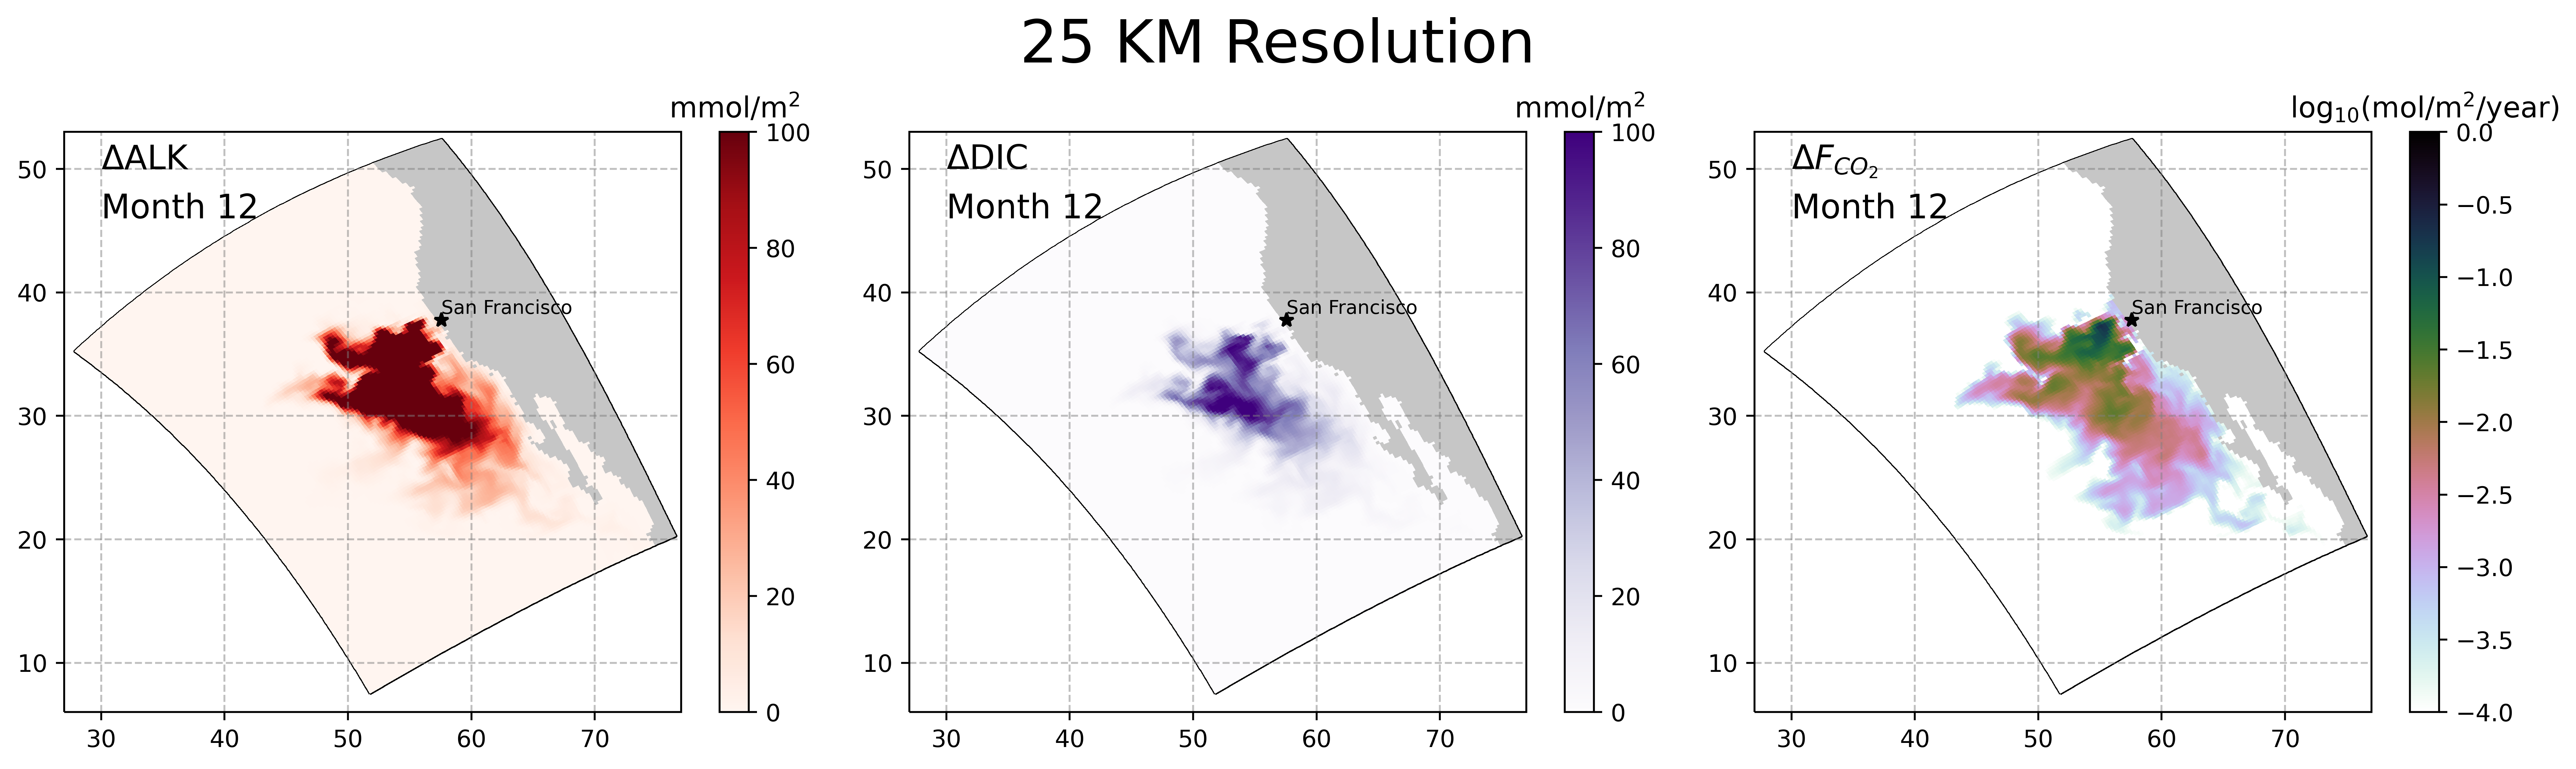

In [168]:
ii=11
cbarmax = 100 #upper colorbar limit!
true_lat = 37.78
true_lon = -122.43+180


fig = plt.figure(figsize=(15,4),dpi=500)
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho, ALK_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=cbarmax,cmap='Reds');
cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^2$')
sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);

ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
ax1.text(30,50,'$\Delta$ALK', fontsize=14)
ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=cbarmax,cmap='Purples'); 
cb = fig.colorbar(sca, ax=ax2)
sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
cb.ax.set_title('mmol/m$^2$')
ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
ax2.text(30,50,'$\Delta$DIC', fontsize=14)
ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


ax3.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
flux_plot = np.log10(flux_diff_1yr[ii]*mask*86400*365/1000); #mol/m^2/year
sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                flux_plot,vmin=-4,vmax=0,
                transform=ccrs.PlateCarree(),
                cmap='cubehelix_r');#
sca.cmap.set_over("black"); sca.cmap.set_under("white"); sca.cmap.set_bad('white')
cb = fig.colorbar(sca, ax=ax3)
sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
cb.ax.set_title('log$_{10}$(mol/m$^2$/year)')
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta F_{CO_2}$', fontsize=14)
plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax3.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax3.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())

ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
plt.tight_layout()
plt.suptitle('25 KM Resolution',y=1.07,fontsize=25)


In [55]:
12*9

108

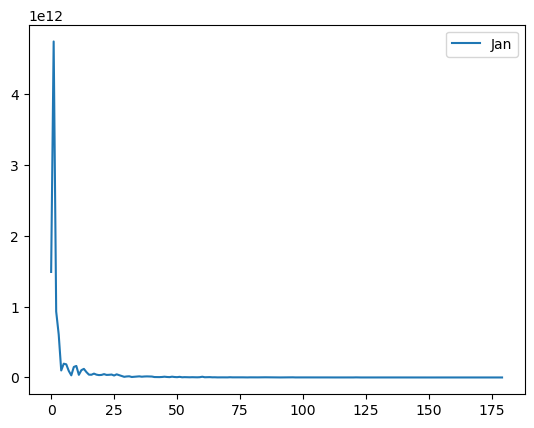

In [68]:
int_fluxJan = np.nansum(np.nansum(flux_diff_Jan*area.values,axis=1),axis=1)*30.42*86400
int_flux1yr = np.nansum(np.nansum(flux_diff_1yr*area.values,axis=1),axis=1)*30.42*86400
int_flux3yr = np.nansum(np.nansum(flux_diff_3yr*area.values,axis=1),axis=1)*30.42*86400

#int_flux = flux_diff_1yr#*area
#int_flux.shape
plt.plot(int_fluxJan,label='Jan')
#plt.plot(int_flux1yr,label='1 yr')
#plt.plot(int_flux3yr,label='3 yr')
plt.legend()


/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix_r").copy()


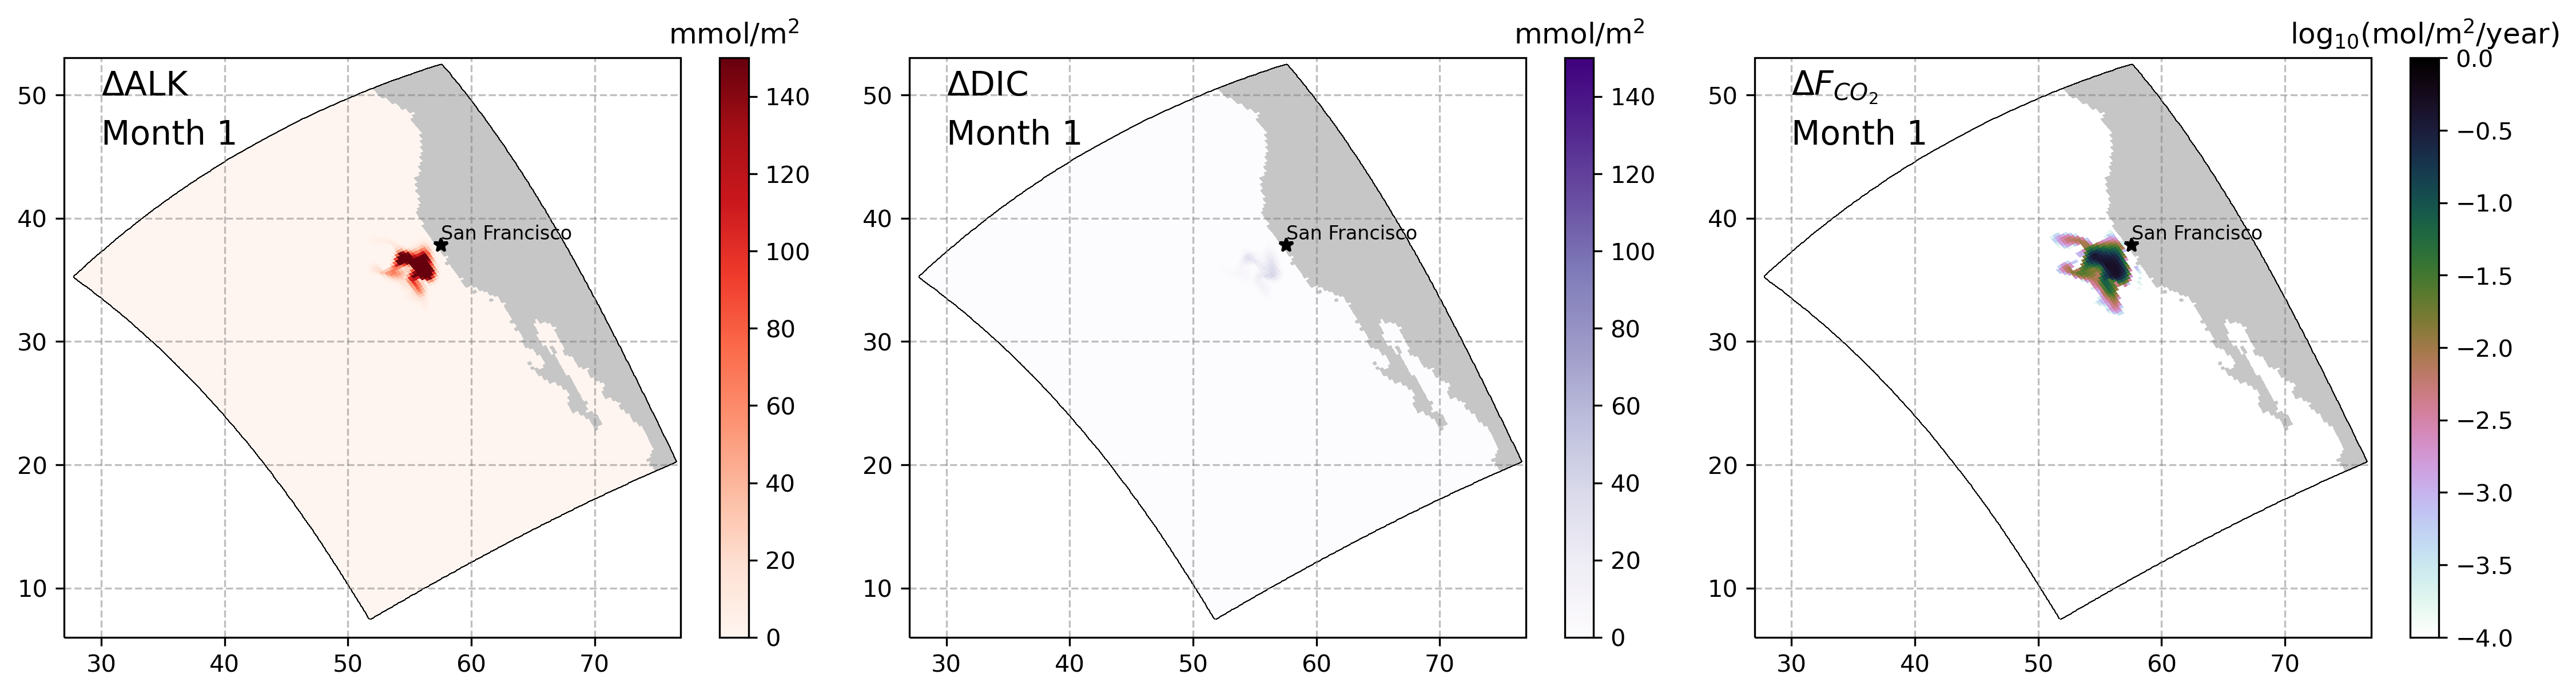

In [110]:

for ii in range(0,1):  #len(bgc_1YR)
    true_lat = 37.78
    true_lon = -122.43+180
    fig = plt.figure(figsize=(15,4),dpi=300)

    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())




    ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho, ALK_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Reds');
    cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^2$')
    sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);

    ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax1.text(30,50,'$\Delta$ALK', fontsize=14)
    ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Purples'); 
    cb = fig.colorbar(sca, ax=ax2)
    sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    cb.ax.set_title('mmol/m$^2$')
    ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax2.text(30,50,'$\Delta$DIC', fontsize=14)
    ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


    ax3.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    flux_plot = np.log10(flux_diff_1yr[ii]*mask*86400*365/1000); #mol/m^2/year
    sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                flux_plot,vmin=-4,vmax=0,
                transform=ccrs.PlateCarree(),
                cmap='cubehelix_r');#
    sca.cmap.set_over("black"); sca.cmap.set_under("white"); sca.cmap.set_bad('white')
    cb = fig.colorbar(sca, ax=ax3)
    sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    cb.ax.set_title('log$_{10}$(mol/m$^2$/year)')
    plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    plt.text(30,50,'$\Delta F_{CO_2}$', fontsize=14)
    plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax3.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax3.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax3.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())

    ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.savefig("vidfiles_lr/%03d.png" % ii,dpi=500)
 #   plt.clf()


In [ ]:
# # t0 = xr.open_dataset(init_file).ocean_time
# # tf = xr.open_dataset(infiles[0]).ocean_time[1]
# # (tf-t0)/86400

# time_diff = 31.0*86400 #January
# total_alk = (xr.open_dataset('ALK_forcing.nc').ALK[1,:]*time_diff)*area
# total_alk = np.nansum(total_alk)


# #TO CHECK what percentage of alk we still have in the domain
# np.nansum(ALK_diff[1])/total_alk


In [164]:
for ii in range(0,108):  #len(bgc_1YR)
    true_lat = 37.78
    true_lon = -122.43+180
    fig = plt.figure(figsize=(10.3,4),dpi=500)

    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

    ALK_forced_1yr = xr.open_dataset(infiles_1YR[ii])['Alk'][1,-1,:,:]
    DIC_forced_1yr = xr.open_dataset(infiles_1YR[ii])['DIC'][1,-1,:,:]  
    ALK_unforced = xr.open_dataset(infiles_ctl[ii])['Alk'][1,-1,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[ii])['DIC'][1,-1,:,:]
    ALK_surf_diff =  ALK_forced_1yr-ALK_unforced
    DIC_surf_diff =  DIC_forced_1yr-DIC_unforced
#    ALK_forced_ws_1yr = (ALK_forced_1yr*H).sum(axis=0)     #mmol/m2
#    DIC_forced_ws_1yr = (DIC_forced_1yr*H).sum(axis=0)    #mmol/m2



    ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho,ALK_forced_1yr*mask, transform=ccrs.PlateCarree(),
                cmap='inferno_r',vmin=2250,vmax=2500);
    cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^3$')
    sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax1.contour(grd.lon_rho-180, grd.lat_rho, ALK_surf_diff, levels=np.linspace(.01,5,20), linewidths=.4, cmap = 'binary', transform=ccrs.PlateCarree());

    ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax1.text(30,50,'Surface ALK', fontsize=14)
    ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_forced_1yr*mask, transform=ccrs.PlateCarree(),
                cmap='viridis_r',vmin=2000,vmax=2350); 
    cb = fig.colorbar(sca, ax=ax2)
    sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax2.contour(grd.lon_rho-180, grd.lat_rho, DIC_surf_diff, levels=np.linspace(.01,5,20), linewidths=.4, cmap = 'binary', transform=ccrs.PlateCarree());

    cb.ax.set_title('mmol/m$^3$')
    ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax2.text(30,50,'Surface DIC', fontsize=14)
    ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


    plt.tight_layout()
    plt.savefig("ALK_lr/%03d.png" % ii,dpi=500)
    plt.clf()

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

<Figure size 5150x2000 with 0 Axes>

In [161]:
np.nanmax(ALK_surf_diff)

11.99806764224195